<img src = "../../Data/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# High-dimensional predictive regression models

We start implementing the first models/algorithms for prediction, and understand to some depth their methodological underpinning 


For the implementations we will rely on another Python toolkit


http://scikit-learn.org/

A python library that provides a variety of tools  for machine learning (e.g., pre-process data, evaluate models, etc), and implements a lot of ML algorithms 

More information can be found here
 http://scikit-learn.org/stable/documentation.html
 
 *Warning: pandas are great for data management and sklearn is useful for ML but they are not (yet) perfectly compatible. sklearn works with numpy objects*

## Summary

In this module we build linear models for regression as linear combination of features extracted from original input data. Key ideas we develop here is how to learn the model and how to evaluate model performance. We discuss the bias-variance tradeoff, and related notions such as stability, overfitting, regularization. We introduce a nice algorithmic framework for predictive modelling with a large number of features, that of penalized likelihood generally and the lasso specifically. 

In [1]:
# We load the relevant modules

%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
#seaborn is a module for figures
import seaborn as sns
import numpy as np
import sklearn

/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Read the curve data

These are our *training data*

In [52]:
x = [x*0.11 for x in range(0, 10)]
y = np.random.uniform(low=0.01, high=0.99, size=(10,))
cdata = pd.DataFrame(data={'x': x, 'y': y}) 
# cdata = pd.read_csv('../../Data/curve_data.csv')

In [53]:
cdata.head()

,x,y
0,0.00,0.894678
1,0.11,0.594623
2,0.22,0.549761
3,0.33,0.221207
4,0.44,0.707998


<AxesSubplot:xlabel='x', ylabel='y'>

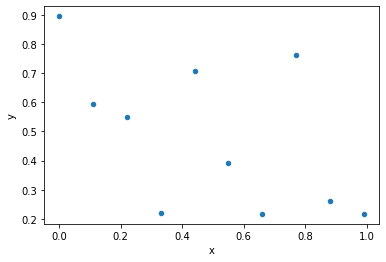

In [54]:
# plot here is a DF method
cdata.plot(x='x',y='y',kind="scatter")

## Our first learning function: linear in $x$

$$ y_i \sim \Gau(f(x_i,\bb) , v)$$

$$ f(x,\mathbf{\beta}) = \beta_0 + \beta_1 x$$

$$ \bb = (\beta_0,\beta_1)^T$$

Remark on the notation: bold-face for vectors, otherwise scalars; bold-face capital letters for matrices

We first import the relevant tools. For predictive modelling, which is the aim here, `LinearRegression` is good enough. I would not use this for inference though. `statsmodels.api` appears a better choice

In [55]:
# importing the relevant sklearn tools

#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

In [56]:
# Notice the class structure
regr  = LinearRegression()

In [57]:
#preparing the data for sklearn - you can appreciate the earlier 
#"not very compatible" comment
# we create an array with data provided by the DF
data = np.array(cdata)

In [58]:
# create now predictors and response - and make sure they are 
# in the right format - they are not by default hence the reshape
X = data[:,0].reshape(10,1)
y = data[:,1].reshape(10,1)

In [59]:
# I do not have to define a column of 1s since intercept can be added
# in the options
# notice the application of the method to the regr instance
regr.fit(X,y)

LinearRegression()

### Predicting new data

We will compute the *learning function* $f(x,\bb)$ on some *test data* 

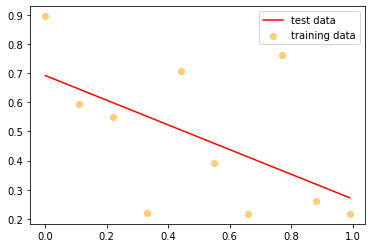

In [60]:
# choose some points to predict - notice reshape and -1! 
X_new = 0.11*np.arange(10).reshape(-1, 1)
#the learned function f(x) at prediction inputs
f_new_pred = regr.predict(X_new) 
# Plot the random data
plt.figure()
# plot training data
plt.scatter(X, y, c="orange", label="training data", alpha=0.5)
# plot predictions 
plt.plot(X_new, f_new_pred, c="red", label="test data")
plt.legend()
plt.show()


## A better learning function: linear in parameters and features, non-linear in input

\begin{equation}
y_i \sim \Gau(f(x_i,\bb) , v)
\end{equation}

$$ f(x,\bb) = \beta_0 + \beta_1 x + \beta_2 x^2 + \ldots \beta_n x^{p-1} $$

The following is a constructive perspective: we create **features**, that is new input variables that are transformations of the original ones. In the above construction the vector of features for the $i$th data point are 

$$\bphi_i =(1,x_i,x_i^2,\ldots,x_i^{p-1})^T$$ 

then 

$$ f(x_i,\bb) = \bb^T \bphi_i$$

Notice that we now have $p$ predictors, even though $x$ is 1-dimensional. The choice of polynomial features is simply for illustration; in fact this is not such a good choice for a number of reasons.

In [62]:
# Getting more features for the given input. 
# Polynomial features are so common that sklearn has a built in function
# for constructing them 
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

from sklearn.preprocessing import PolynomialFeatures as plf
# the argument specifies the polynomial order, here we choose up to power 3
poly = plf(3)
F = poly.fit_transform(X) #F for fearure matrix
print(F) # notice that the intercept is now added by default

[[1.       0.       0.       0.      ]
 [1.       0.11     0.0121   0.001331]
 [1.       0.22     0.0484   0.010648]
 [1.       0.33     0.1089   0.035937]
 [1.       0.44     0.1936   0.085184]
 [1.       0.55     0.3025   0.166375]
 [1.       0.66     0.4356   0.287496]
 [1.       0.77     0.5929   0.456533]
 [1.       0.88     0.7744   0.681472]
 [1.       0.99     0.9801   0.970299]]


In [63]:
regr  = LinearRegression(fit_intercept=False)
regr.fit(F,y)

LinearRegression(fit_intercept=False)

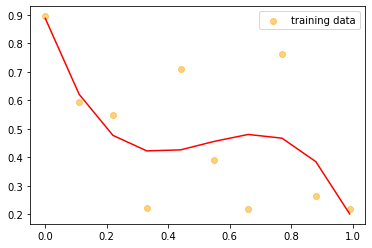

In [66]:
# predict with the new model: note that we need to generate features
# for the test data
X_new = 0.11*np.arange(10).reshape(-1, 1)
F_new = poly.fit_transform(X_new)
f_new_pred = regr.predict(F_new) 
plt.figure()
plt.scatter(X, y, c="orange", label="training data", alpha=0.5)
plt.plot(X_new, f_new_pred, c="red")

plt.legend()

## Behind the scenes: the learning function, convexity and algorithm

In more generality: output $y_i$ (1-d), input $\bx_i$ (multi-d), features vector for each individual $i$, $\bphi_i$, a linear model for the learning function $f(\bx_i,\bb) = \bphi_i^T \bb$

The first part of the model $y_i \sim \Gau(f(\bx_i,\bb) , v)$ quantifies the datapoint-model match. Every data point **scores** the model by how predictable it is by the model, i.e., according to the density $p(y_i | \bx_i)$; the higher the density the better the model predicts the data point. 

It is more convenient to work in a different scale: 

$$-\log p(y_i \mid \bx_i)$$

Now this a **datapoint-model mismatch**, the lower this is the better. 
The overall **data-model mismatch** is obtained by aggregating the evidence by all data. Assuming that the data are independent we have that 

$$p(y_1,\ldots,y_n \mid \bx_1,\ldots,\bx_n) = p(y_1 \mid \bx_1) \cdots p(y_n\mid \bx_n)$$

Having also assumed Gaussian errors, 

$$-\log p(y_i | \bx_i) = {1 \over 2 v}(y_i - f(\bx_i,\bb))^2 - {1 \over 2} \log v - {1\over 2} \log(2 \pi)$$

from which we obtain the **loss function**, here  the **negative log-likelihood**

$$L(\bb,v) =  {1 \over 2 v} \sum_{i=1}^n (y_i - f(\bx_i,\bb))^2 - {n \over 2} \log v$$

This is a nice function to optimize. First, note that one can optimize over $\bb$ regardless of the value of $v$: 


$$
\whbb = \arg \min_\bb L(\bb,v)
$$

Once $\whbb$ has been obtained, we can easily optimize over $v$.  $L(\bb,v)$ as a function of $\bb$ is **convex**, in fact it is a quadratic form and one way to optimize is to reduce the computation to a solution of a linear system  

What `LinearRegression.fit` does is solve the least-squares minimization problem. 
Then, the learning function is estimated by 

$$\hf_n(\bx) = f(\bx,\whbb)$$ 

## Model evaluation

Lets plot the training $y_i$ vs $\hf_n(\bx_i)$. We will also report the **square of the correlation coefficient** between the two samples. This squared correlation coefficient is used so frequently that has a name: coefficient R-squared

A small calculation shows that 

$$R-squared = 1 - {\sum_i (y_i - \hf_n(\bx_i))^2 \over \sum_i (y_i - \ybar)^2}$$

hence large $R-squared$ is equivalent to small **sum of squared errors**


Text(0.5, 1.0, 'R-squared equals 0.481')

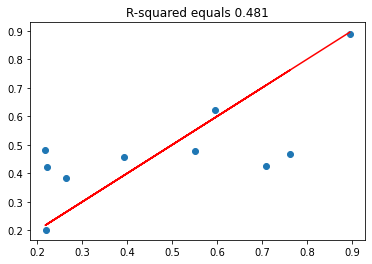

In [67]:
# plot predicted vs observed - y_hat = f(x)

y_hat = regr.predict(F)
plt.figure()
plt.scatter(x=y,y=y_hat) 
plt.plot(y,y,c="red")
rho = pd.Series(y[:,0]).corr(pd.Series(y_hat[:,0]))
plt.title('R-squared equals %.3f' %rho**2)


The big question is - statistically speaking - what do these sample statistics, such as R-squared, estimate and whether they are doing a good job at estimating it 

The following are some *population* quantities worth estimating. Let $(x^*,y^*)$ be a randomly chosen *test* datapoint from the same phenomenon that has generated the *training data* $(x_i,y_i),i=1,\ldots,n$. What would be interesting to compute - if possible - is 

+ Mean Squared Error (MSE):

$$ MSE_n = \E[(y^* - \hf_n(\bx^*))^2]$$ 

+ Squared correlation between $y^*$ and $\hf_n(\bx^*)$:

$$ R^2 = \Cor(y^*,\hf_n(\bx^*))^2$$

Replacing population expectation with sample averages, and using the training data as samples, we get the quantities we introduced earlier. Therefore, those are statistical estimators of the population quantities above. Are they any good though? 

We will return to this question but for the time being lets consider an alternative estimator of these quantities, the so-called **leave-one-out cross-validation estimator**. Intuitively it is simple: 

+ Use all data points but the $i$th to estimate the learning function: 

$$
\hf_{n-1,-i}(\bx)
$$

+ Using the estimated learning function, predict the $i$th training data point: 

$$\hf_{n-1,-i}(\bx_i)$$

+ Estimate the MSE or $R^2$ by computing

$$(y_i - \hf_{n-1,-i}(\bx_i))^2$$

+ We can actually do this for each data point $i$ and then average the estimates: 

$${1 \over n} \sum_{i=1}^n (y_i - \hf_{n-1,-i}(\bx_i))^2$$ 

We can implement this ourselves - or use some `sklearn` functions too

Text(0.5, 1.0, 'Leave-one-out CV R-squared equals 0.120')

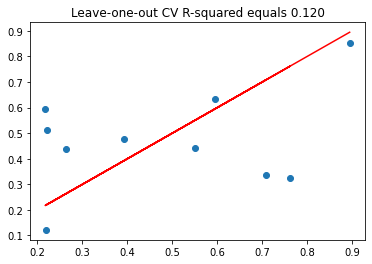

In [68]:
from sklearn.model_selection import cross_val_predict as cvp
y_hat_cv = cvp(regr, F, y, cv=10) # this is leave-one-out CV when cv=10      
                                  # and 10 because n=10
plt.figure()
plt.scatter(x=y,y=y_hat_cv) 
plt.plot(y,y,c="red")
rho = pd.Series(y[:,0]).corr(pd.Series(y_hat_cv[:,0]))
plt.title('Leave-one-out CV R-squared equals %.3f' %rho**2)

### Working with a more flexible model

We repeat this analysis but working with polynomial of order 7; in this case the number of parameters is almost the same as number of observations

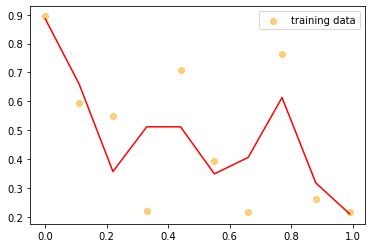

In [69]:
order = 7
poly = plf(order)
Flarge = poly.fit_transform(X)
regr.fit(Flarge,y)

X_new_= 0.11*np.arange(10).reshape(-1, 1)
F_new = plf(order).fit_transform(X_new)
f_new_pred = regr.predict(F_new) 
plt.figure()
plt.scatter(X, y, c="orange", label="training data", alpha=0.5)
plt.plot(X_new, f_new_pred, c="red")

plt.legend()

Visually the estimated learning function looks good and very similar to the one we obtained with the 3rd order polynomial. 

Visual inspection is **crucial** - but often not an option. Lets look at our model evaluation criteria too - these are pretty much always available

Text(0.5, 1.0, 'R-squared equals 0.609')

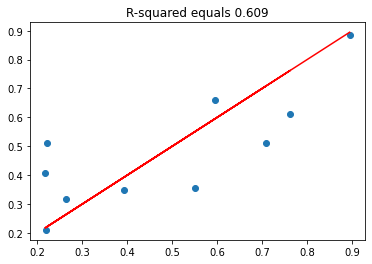

In [70]:
y_hat = regr.predict(Flarge)
plt.figure()
plt.scatter(x=y,y=y_hat) 
plt.plot(y,y,c="red")
rho = pd.Series(y[:,0]).corr(pd.Series(y_hat[:,0]))
plt.title('R-squared equals %.3f' % rho**2)


Text(0.5, 1.0, 'Leave-one-out CV R-squared equals 0.046')

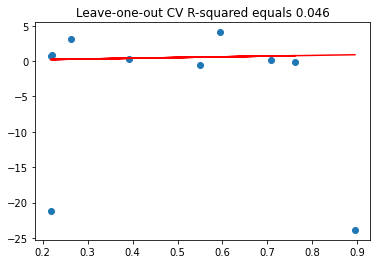

In [71]:
y_hat_cv = cvp(regr, Flarge, y, cv=10)

plt.figure()
plt.scatter(x=y,y=y_hat_cv) 
plt.plot(y,y,c="red")
rho = pd.Series(y[:,0]).corr(pd.Series(y_hat_cv[:,0]))
plt.title('Leave-one-out CV R-squared equals %.3f' % rho**2)

Interesting!! This is example of what we might call loosely **overfitting** but more things are going on here (e.g. leverage). What should note is that at this *model complexity* the procedure we have followed to estimate the learning function has become very **unstable**: it is overly sensitive to a small change in the training data, and in particular to two data points 



#### Exercise
Pick one of the two extremal points in the input space, the ones close to a y value of 0, learn the model and plot the solution for the leave-one-out case. See how the estimated function varies when each of the points are left out and compare with the estimated function when all the data are used

In [ ]:
# Index to the point to be excluded from model


# Your code here

# Remove this position from input data


# Retrain


## The bias-variance tradeoff in Statistics and Machine Learning

The picture tells it all! (Taken from Bishop's book)

<img src="../images/bias_variance_bishop.png" width="400">

This is typical: 

+ *Procedures* with *few degrees of freedom* are stable but the learning function they estimate can be systematically far off from the optimal one (**bias**). They would have comparable R-squared and leave-one-out CV R-squared

+ *Procedures* with *high degrees of freedom* are sensitive to training data (**variance**) but the learning function they estimate might not have systematic differences from the optimal one. They would have near-1 R-squared and near-0 leave-one-out CV R-squared 

It is important to understand that these properties involve **both the model and the loss function** - this is why I tactically used the vague term *procedure* above: it is the combination of both - what we might call "algorithm" - that matters



The following figure, taken also from Bishop, shows the estimated mean squared error - blue is in-sample, red is analogous to leave-one-out CV - for increasing values of $p$ (denoted by $M$ in the fig). 

<img src="../images/bishop_overfit.png">

We want **algorithms that can strike a good bias-variance tradeoff**!

The remaining of this lecture is devoted to:

1. Giving such algorithms: e.g. the so-called LASSO; they use the same linear-in-features model but a different loss function
2. Discussing how to estimate $MSE_n$ from data; we will revisit CV

## A framework for good predictive algorithms: penalized likelihood methods

We now see *algorithms* that achieve a good bias-variance tradeoff and allow us to fit linear models with very large number of features, even much larger than the number of observations - e.g $p \approx e^n$. The key structure that they try to exploit, and do well when this structure is consistent with the data, is that of **sparsity**, i.e., that only a small number of terms in the linear model are needed to get good predictions. The training will select the few important features




These *algorithms* use the *same linear models* we have seen before. But they use *different loss functions* 

We focus on the coefficients $\bb$: since their estimation did not require knowledge of $v$, we simplify (and rescale) the loss function we derived earlier to 

$$L(\bb) =  {1 \over 2 n} \sum_{i=1}^n (y_i - f(\bx_i,\bb))^2$$ 

The class of algorithms we discuss now are in the family of so-called **shrinkage methods**; they are based on changing the loss function to 

$$L(\bb) =  {1 \over 2 n} \sum_{i=1}^n (y_i - f(\bx_i,\bb))^2 + \lambda \sum_{j=0}^{p-1} g(\beta_j)$$ 

where $g(\beta_j)$ is a **penalty** term, that penalizes $\beta_j$ when $\beta_j \neq  0$; recall that $\beta_j = 0$ means that feature $j$ (e.g., $j-1$ polynomial order) is dropped from the model


This family of loss functions are called penalized likelihood. The following are some common examples of penalties - and the names the corresponding algorithms are known with: 

+ LASSO: $g(\beta) = |\beta|$

+ ridge regression: $g(\beta) = \beta^2$

+ Elastic Net/SCAD/MC+/Reciprocal LASSO/...

Again the picture says it all: 

<img src = "../images/penalties.png" width ="400">

Some remarks: 

+ Feature standardization: 
    + Different coefficients are penalized in the same way: this only makes sense if the different coefficients are comparable. Consider the following silly example that makes the point: suppose I want to build a simple predictive model for the time it takes to get with my bike from my home to a given location in Barcelona just in terms of the vertical dispacement, $v$, and horizontal dispacement $h$, in terms of data $(y_i,v_i,h_i)$ of times it took in past trips $y_i$ when the displacements were $v_i$ and $h_i$. My house is on the beach and I mostly move along the coast, so I decided to record the horizontal discplacement in kilometers and the vertical dispacement in meters. My model is 
    $$ y_i = \beta_1 h_i + \beta_2 v_i + error$$
        I should expect that $\beta_1 \approx 1000 \beta_2$ - they will be on completely different scales.
        
    + Penalized likelihood algorithms require that the features have been standardized to have comparable scales. We often subtract the sample mean and divide by the standard deviation across replications

+ The role of $\lambda$:
    + This **hyperparameter** allows us to trade bias with variance, creating a continuum of mean squared errors along which we try to choose an optimal $\lambda$ - hence an optimal predictive model. 
    + $\lambda \to 0$ leads to small bias/large variance, $\lambda \to \infty$ to large bias/small variance. 
    + Lets revisit now the bias-variance tradeoff picture: ridge regression with varying $\lambda$s: 
    <img src="../images/bias_variance_bishop.png" width="400">

### Lasso in action: the curve data with many many features

In [72]:
order = 9
poly = plf(order)
Flarge = poly.fit_transform(X)[:,1:] # drop the intercept column

# standardisation of input is critical: We will use sklearn to do this

# generic lasso regression object
from sklearn.preprocessing import scale as scl
Flarge = scl(Flarge)

In [73]:
from sklearn.linear_model import Lasso
#alpha is what was lambda in our notation
regr_lasso = Lasso(alpha=0.0001, fit_intercept=False,warm_start=True,max_iter=1000000)

# application to our data and model
regr_lasso.fit(Flarge,y)

# see coefficients
print(regr_lasso.coef_)

[-0.80666167  1.25628872 -0.         -0.63960441 -0.         -0.
 -0.         -0.          0.01807245]


Text(0.5, 1.0, 'R-squared equals 0.054')

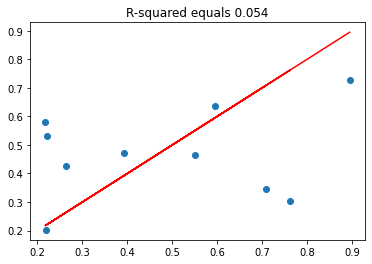

In [74]:
# CV R2 

y_hat_cv = cvp(regr_lasso, F, y, cv=10)
plt.figure()
plt.scatter(x=y,y=y_hat_cv) 
plt.plot(y,y,c="red")
rho = pd.Series(y[:,0]).corr(pd.Series(y_hat_cv))
plt.title('R-squared equals %.3f' %rho**2)

### Further insights & observations on lasso

+ Sparsity: increasing values of $\lambda$ have the effect that an increasing number of estimated coefficients are exactly zero
+ Variable selection: hence, implictly lasso also performs a principled feature selection - but this is not an aspect we will explore here
    + Lets see these properties in action in our example. Lets look at the coefficients for a range of $\lambda$ values

.

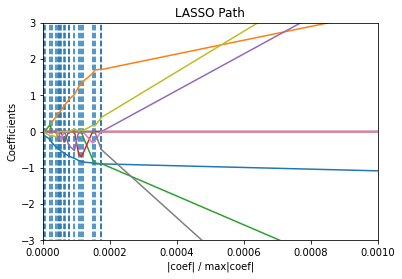

In [75]:
from sklearn.linear_model import lars_path 

alphas, _, coefs = lars_path(Flarge, y[:,0], method='lasso', 
                             verbose=True, max_iter = 100000)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.xlim(0,0.001)
plt.ylim(-3,3)
plt.show()

+ Convexity: the loss function is convex; this is because the least squares function is convex (a quadratic function) and the penalty is convex too. This allows very efficient estimation using **convex optimization** algorithms. 
    + A common choice is **coordinate-wise descent**. This is an iterative algorithm that scans through each coefficient and updates it using information about the values of all other coefficients. 
    + For standardized features $\bx_1,\bx_2,\ldots$ each coefficient is updated as: 
$$\beta_j \leftarrow \mathcal{S}_{\lambda}\left({1 \over n} \boldsymbol{r}_{-j}^T \bx_j\right )$$
      where $\boldsymbol{r}_{-j}$ is the vector of residuals from the model with $\beta_j = 0$ and the soft-thresholding operator is:
      $$\mathcal{S}_{\lambda}(\beta) = \mathrm{sign}(\beta) \max\{|\beta| - \lambda,0\}$$
    + The fast optimization is a major attraction for the lasso 
      + Coordinate-wise descent is implemented at a cost that grows only linearly in $n$ and $p$: it is a practical solution for Big Data and Big Models  

## Choosing the regularization hyperparameter

Given an estimator of $MSE_n$ we can choose $\lambda$ to achieve an MSE as small as possible. For example leave-one-out cross validation. 

Another possibility is to use a **model selection** criterion. Model selection criteria balance in-sample fit with **model complexity**. 

First, we try leave-one-out CV in our example. 

### Leave-one-out CV selection of $\lambda$ for the curve data

Lets try and do this using the leave-one-out CV we have already discussed. We will try a range of different $\lambda$s, for each of which we will estimate the MSE by leave-one-out CV, plot the resultant curve and try to identify a good $\lambda$

The procedure is computationally intensive - this will not manifest here where $n=10$

We will use `GridSearchCV` to carry out the outer (grid search and CV) loop

In [76]:
from sklearn.model_selection import GridSearchCV

# you may wonder why I set random_state now and did not do so before
lasso = Lasso(random_state=0,max_iter=3000000) 
alphas = np.array([0.000007, 0.00002, 0.00004, 0.00005,0.00008,0.0001,0.00012, 0.00015,0.0002,0.00025,0.0003,0.0004,0.0005,0.0006,0.0007,0.002])

tuned_parameters = [{'alpha': alphas}]
n_folds = 10 # remember that for this dataset this is leave-one-out

In [77]:
# create a scorer to evaluate performance

from sklearn.metrics import mean_squared_error, make_scorer 

## ALWAYS read carefully documentation. copying here from make_scorer
## greater_is_better : boolean, default=True
# "Whether score_func is a score function (default), meaning high is 
# good, or a loss function, meaning low is good. 
# In the latter case, the scorer object will sign-flip 
# the outcome of the score_func.
mse = make_scorer(mean_squared_error,greater_is_better=False)


clf = GridSearchCV(lasso, tuned_parameters, scoring = mse, 
                   cv=n_folds, refit=False)

clf.fit(Flarge, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
std_error = scores_std / np.sqrt(n_folds)

/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02204133392360827, tolerance: 3.91761570377957e-05
  model = cd_fast.enet_coordinate_descent(
/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01535134149623063, tolerance: 5.6683205848926256e-05
  model = cd_fast.enet_coordinate_descent(
/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020784179548831716, tolerance: 5.7581425532863385e-05
  model = cd_fast.enet_coordinate_descent(
/Users/polinab/.virtualenvs/base/li

(7e-06, 0.002)

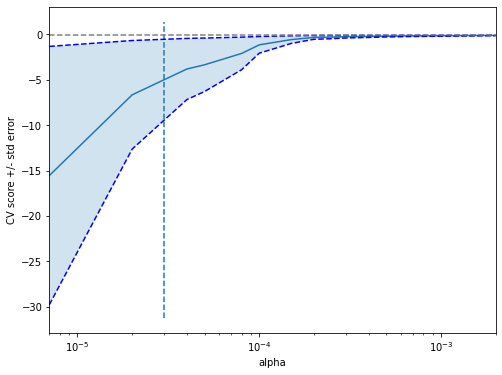

In [80]:
# Plotting the results

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
ymin, ymax = plt.ylim()
plt.vlines([0.00003] ,ymin, ymax, linestyle='dashed')
plt.xlim([alphas[0], alphas[-1]])

#### Exercise
Refit the lasso with the regularised *alpha* ($\lambda$) parameter that we just found that maximizes the CV score. Check the number of parameters that have been shrunk to zero.

Report the leave-one-out CV $R^2$ coefficient. Plot leave-one-out  predicted versus actual output values 


In [ ]:
# Refitting the lasso with that regularising parameter
# Hint: use Lasso()
# Your code here


In [ ]:
# CV R2 and plot 
# Hint: Use cvp() on the previous model, then plot y versus y_hat_cv as we did before
# Your code here


## Some hints for practitioners


+ Building good predictive models with hundreds or even thousands of features is a real possibility
+ LASSO combines least squares fit with a penalty for model complexity; it relies on an additional *regularizing hyperparameter*
+ Sklearn module `LinearRegression` can be used for predictive modelling. `Lasso` can be used to fit a lasso model for given value of regularization hyperparameter. `lars_path` can return all the possible lasso solutions for all values of the regularization hyperparameter and is a useful tool in exploring the different models
+ The choice of regularization hyperparameter is a model choice problem; you can use both cross validation to estimate the MSE for each possible value of the hyperparameter and use a grid search to identify good values for the hyperparameter - `GridSearchCV` is useful wrapper for this. Less data and computationally intensive method is to use a model selection criterion, e.g. AIC, and a simple formula exists for the lasso
+ For inference with a linear model, i.e., obtaining confidence intervals, p-values etc, `LinearRegression` is  entirely inappropriate. Use other modules, e.g., `statsmodels.api`. 
+ Inference with the output of the lasso model is non-trivial and subject of more advanced material. Although lasso implictly selects a model by dropping variables, you should not over-interpret the variables that have been selected. Its merit is primary in getting a good predictive model. Lasso is helpful in screening some variables, so it is often used as a first step to be followed by a more formal selection procedure. Generally, these questions fall under the theme of *post-selection* inference

## References

Hastie, T., Tibshirani, R., Friedman, J., 2009. *Elements of Statistical Learning*. 2nd Edition. Chapters 1, 2, Section 3.4; More advanced 3.8,3.9,7.10  https://web.stanford.edu/~hastie/ElemStatLearn/

Bishop, C.M. *Pattern recognition and machine learning*. Chapter 1, Sections 3.1, 3.2